# Hyperparameter optimization

After evaluating the performance of different modelling frameworks with baseline hyperparameters, the performance of the Gradiendt Boosting Classifier showed the highest accuracy score. Hence, we are proceeding with the Gradient Boosting Classifier (GBC), or the `sklearn` class `GradientBoostingClassifier()`.

### Gradient Boosting Classifier
#### What is Gradient Boosting?
Before we start examining the hyperparameters of the Gradient Boosting Classifier (`GradientBoostingClassifier()`), it would be a good idea to recap on what this classifier is. So what is GBC? According to [this source](https://medium.com/analytics-vidhya/introduction-to-gradient-boosting-classification-da4e81f54d3):

>Gradient Boosting is the grouping of gradient descent and boosting. In gradient boosting, each new model minimizes the loss function from its predecessor using the Gradient Descent Method. This procedure continues until a more optimal estimate of the target variable has been achieved.

GBC, therefore, is a sequential ensemble model - meaning that in order to achieve great accuracy, a number of models need to run. Importantly, this cannot be done in parallel (hence, 'sequential'). This is important to note, as GBCs can get computationally costly, especially in a large hyperparameter space.

#### Hyperparameters of GBC (and `GradientBoostingClassifier()`)
The Hyperparameters of GBC are quite neatly covered in the [previously-used source](https://medium.com/analytics-vidhya/introduction-to-gradient-boosting-classification-da4e81f54d3). Here is a brief overview of most important hyperparameters:

- **Learning rate**: by using gradient descent, this hyperparameter affects the speed of algorithm convergence. There is a tradeoff between the value size with smaller values minimizing overfitting (but taking more time until convergence) and larger values, while potentially not reaching an optimal fit, lead to a faster convergence.

- **Number of trees**: how many trees are optimal to minimize the loss function? 

- **Depth of trees**: the number of splitsin a tree.

- **Subsampling**: what is the proportion of trainig data used for training a tree? 

All this briefly summarized, let's start the analysis.

## Setup

In [1]:
# Install packages
#!pip install hyperopt

In [2]:
# Libraries
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# GBC
from sklearn.ensemble import GradientBoostingClassifier

# Hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic

## Import the data


In [3]:
train_df = pd.read_csv("clean_data/train.csv")
test_df = pd.read_csv("clean_data/test.csv")

X_test = test_df.iloc[:,:27]
y_test = test_df['compliance_2020']

X_train = train_df.iloc[:,:27]
y_train = train_df['compliance_2020']

print(f'X_train dims: {X_train.shape}')
print(f'y_train dims: {y_train.shape}')

print(f'X_test dims: {X_test.shape}')
print(f'y_test dims: {y_test.shape}')

X_train dims: (388, 27)
y_train dims: (388,)
X_test dims: (156, 27)
y_test dims: (156,)


## Hyperparameter optimization
A great resources for hyperparameter optimization using the `hyperopt`library can be found [here](https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce).

Running the hyperparameter optimization.

In [4]:
# GBC

def hyperopt_accuracy(params):
    gbc = GradientBoostingClassifier(**params, random_state = 999).fit(X_train, y_train)
    return np.mean(gbc.predict(X_test) == y_test) # accuracy score, faster than sklearn metrics

space_hp_gbc = {
    'learning_rate': hp.choice('learning_rate', np.arange(0.001, 0.4, 0.001)),
    'n_estimators': hp.choice('n_estimators', range(1, 200, 1)),
    'subsample': hp.choice('subsample', np.arange(0.01, 1, 0.01)),
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,27)),
    'criterion': hp.choice('criterion', ["friedman_mse", "squared_error"]),
}

def f(params):
    global best_acc
    global best_params
    acc = hyperopt_accuracy(params)
    if acc > best_acc:
        best_acc = acc
        best_params = params
        print('new best:', best_acc, best_params)
    return {'loss': -acc, # see the comment below
            'status': STATUS_OK}

best_acc = 0
best_params = None
trials = Trials()
best = fmin(f, space_hp_gbc, algo = tpe.suggest, max_evals = 800, trials = trials)

# Comment regarding 'negative accuracy' (from the referenced source):
## Since we are trying to maximize the accuracy (acc in the code above), 
## we must negate this value for hyperopt, since hyperopt only knows how to minimize a function. 
## Minimizing a function f is the same as maximizing the negative of f.

new best:                                                                       
0.9102564102564102                                                              
{'criterion': 'friedman_mse', 'learning_rate': 0.371, 'max_depth': 15, 'max_features': 12, 'n_estimators': 118, 'subsample': 0.99}
new best:                                                                       
0.9230769230769231                                                              
{'criterion': 'squared_error', 'learning_rate': 0.031, 'max_depth': 16, 'max_features': 23, 'n_estimators': 98, 'subsample': 0.46}
new best:                                                                       
0.9294871794871795                                                              
{'criterion': 'squared_error', 'learning_rate': 0.015, 'max_depth': 16, 'max_features': 19, 'n_estimators': 95, 'subsample': 0.78}
new best:                                                                       
0.9358974358974359                      

Let's print the best accuracy score and the hyperparameter set.

In [5]:
print(f'Best accuracy score: {best_acc}')
print(f'Hyperparameter set for best accuracy score:\n{best_params}')

Best accuracy score: 0.9358974358974359
Hyperparameter set for best accuracy score:
{'criterion': 'squared_error', 'learning_rate': 0.379, 'max_depth': 15, 'max_features': 7, 'n_estimators': 86, 'subsample': 0.8200000000000001}


To make sure that we achieve this accuracy with the given hyperparameters, let's run this as a model and return the model's accuracy.

In [6]:
# The best model (which is not found on every run)
gbc2 = GradientBoostingClassifier(**best_params, random_state = 999).fit(X_train, y_train)
print(f'Accuracy: {np.mean(gbc2.predict(X_test) == y_test)}')

Accuracy: 0.9358974358974359


Let's plot the accuracy values over each iteration with the baseline accuracy as the reference point.

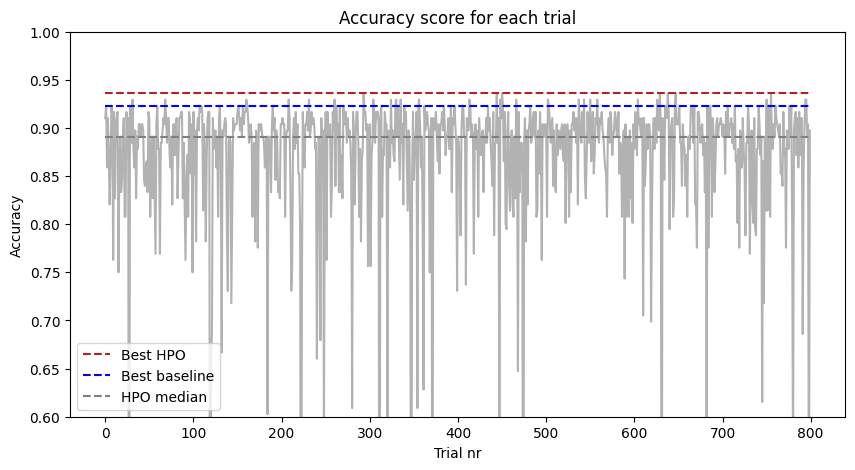

In [37]:
# Data
accs = [-t['result']['loss'] for t in trials.trials]
iters = np.arange(len(accs))

# plot
plt.figure(figsize = [10,5])
plt.plot(iters, accs, color = 'grey', alpha = 0.6)
# Add the baseline accuracy 0.923077
plt.hlines(np.max(accs), xmin = 0, xmax = np.max(iters), color = 'firebrick', 
           label = 'Best HPO', linestyles = 'dashed')
plt.hlines(0.923077, xmin = 0, xmax = np.max(iters), color = 'blue', 
           label = 'Best baseline', linestyles = 'dashed')
plt.hlines(np.median(accs), xmin = 0, xmax = np.max(iters), color = 'grey', 
           label = 'HPO median', linestyles = 'dashed')
plt.legend()
plt.ylim([0.6,1.0])
plt.title('Accuracy score for each trial')
plt.ylabel('Accuracy')
plt.xlabel('Trial nr')
plt.show();

Let's plot the values of parameters and accuracy

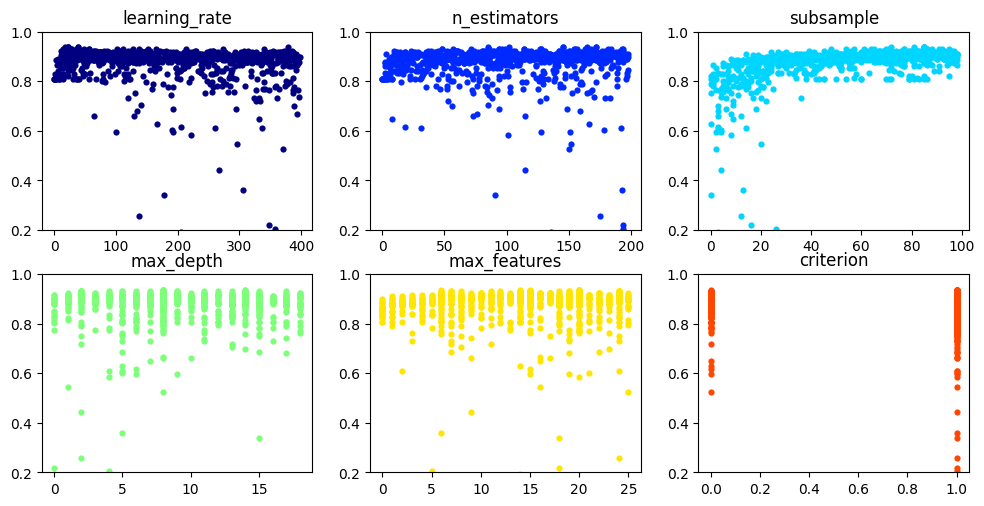

In [7]:
# Plot for parameters
## Tutorial: https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce
parameters = ['learning_rate', 'n_estimators',
              'subsample', 'max_depth', 
              'max_features', 'criterion']

f, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    # print (i, val)
    # Getting the hyperparameter and loss values with list comprehension
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    # Making the necessary sorting
    xs, ys =  zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    # Plot
    axes[int(i/3),int(i%3)].scatter(xs, ys, 
                          s=20, 
                          linewidth=0.01, 
                         # alpha= 0.5,
                          color=cmap(float(i)/len(parameters))
                                   )
    axes[int(i/3),int(i%3)].set_title(val)
    axes[int(i/3),int(i%3)].set_ylim([0.2,1.0])
    
plt.show();

In [8]:
# Another best model (which is not found on every run)
gbc2 = GradientBoostingClassifier(criterion = 'squared_error',
                                 learning_rate = 0.156,
                                 max_depth = 3,
                                 max_features = 25,
                                 n_estimators = 111,
                                 subsample = 0.8,
                                 random_state = 999).fit(X_train, y_train)
print(f'Accuracy: {np.mean(gbc2.predict(X_test) == y_test)}')

Accuracy: 0.9423076923076923
